In [13]:
import nltk
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('output.csv')

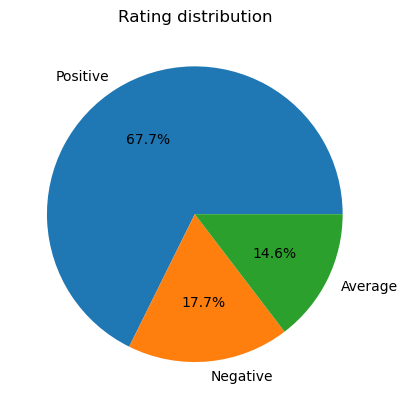

In [6]:
rating_dist = data['rating'].value_counts()/len(data)
plt.pie(rating_dist, labels=['Positive','Negative','Average'],
       autopct = '%1.1f%%')
plt.title("Rating distribution")
plt.show()

In [7]:
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

In [9]:
data['body_len'] = data['review'].apply(lambda x: len(x) - x.count(" "))
data['punct%'] = data['review'].apply(lambda x: count_punct(x))

tfidf_vect = TfidfVectorizer(analyzer=clean_text)
X_tfidf = tfidf_vect.fit_transform(data['review'])
X_tfidf_feat = pd.concat([data['body_len'], data['punct%'], pd.DataFrame(X_tfidf.toarray())], axis=1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data[['review', 'body_len', 'punct%']], data['rating'])

tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['review'])

tfidf_train = tfidf_vect_fit.transform(X_train['review'])
tfidf_test = tfidf_vect_fit.transform(X_test['review'])

X_train_vect = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

In [11]:
rf = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1)

start = time.time()
rf_model = rf.fit(X_train_vect, y_train)
end = time.time()

fit_time = (end - start)

start = time.time()
y_pred = rf_model.predict(X_test_vect)
end = time.time()

pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='Positive', average='weighted')
print('Precision: {} / Recall:{} / Accuracy: {}\n'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))
print('Fit time: {} / Pred time: {}'.format(fit_time, pred_time))

Precision: 0.625 / Recall:0.658 / Accuracy: 0.658

Fit time: 0.8681635856628418 / Pred time: 0.14406847953796387


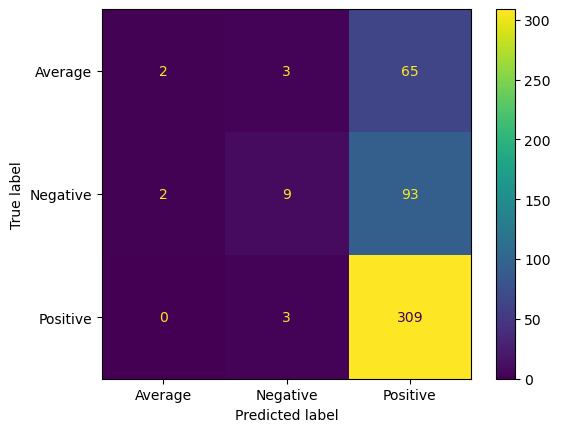

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay

labels = np.unique(y_test)
mat = confusion_matrix(y_test, y_pred, labels = labels)
ConfusionMatrixDisplay(mat, display_labels=labels).plot()

In [27]:
gb = GradientBoostingClassifier(n_estimators=150, max_depth=11)

start = time.time()
gb_model = gb.fit(X_train_vect, y_train)
end = time.time()

fit_time = (end - start)

start = time.time()
y_pred = gb_model.predict(X_test_vect)
end = time.time()

pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='Positive', average='weighted')
print('Precision: {} / Recall:{} / Accuracy: {}\n'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))
print('Fit time: {} / Pred time: {}'.format(fit_time, pred_time))

Precision: 0.613 / Recall:0.665 / Accuracy: 0.665

Fit time: 329.51587319374084 / Pred time: 0.1299750804901123


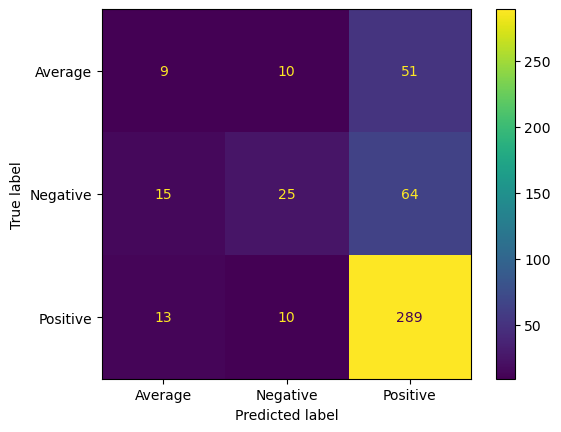

In [28]:
labels = np.unique(y_test)
mat = confusion_matrix(y_test, y_pred, labels = labels)
ConfusionMatrixDisplay(mat, display_labels=labels).plot()

Final result of using Random Forest and Gradient Boosting classifier models is an accuracy of 65% percentage. Next steps could be looking at implementing other models onto the data. In addition, expanding the dataset to include reviews with more average and negative ratings to will help remove present bias for positive rating.  